Device: cpu
Train / Test: 60000 10000
[Joint] epoch 1/6  Loss(train)=0.4321  Acc(test)=0.8638
[Joint] epoch 2/6  Loss(train)=0.2158  Acc(test)=0.8772
[Joint] epoch 3/6  Loss(train)=0.1853  Acc(test)=0.9121
[Joint] epoch 4/6  Loss(train)=0.1679  Acc(test)=0.9165
[Joint] epoch 5/6  Loss(train)=0.1569  Acc(test)=0.9138
[Joint] epoch 6/6  Loss(train)=0.1492  Acc(test)=0.9239

=== JOINT SUMMARY (C=0.5) ===
Image MSE (test): 57.7784
d–d̂  MSE (test): 0.011227
Accuracy  (test): 0.9239


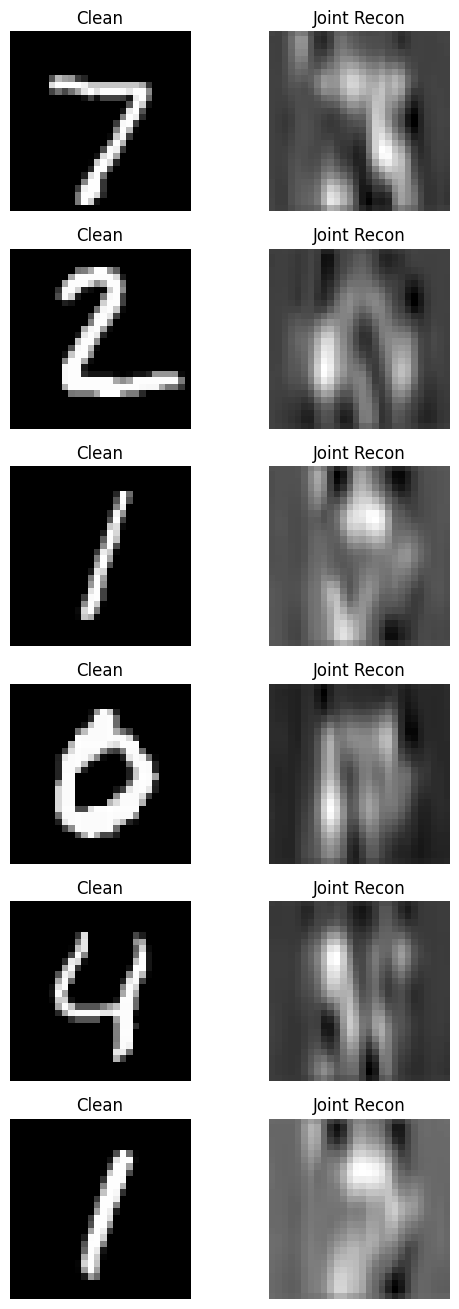

In [ ]:
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from skimage.transform import radon
import matplotlib.pyplot as plt

SEED = 123
torch.manual_seed(SEED); np.random.seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

ANGLES = 5
DETECTORS = 25
I0 = 60.0
ANGLES_DEG = np.linspace(0, 180, ANGLES, endpoint=False)

BATCH_SIZE = 128
NUM_WORKERS = 0     
PIN_MEMORY  = False
DATA_DIR    = "./data"

LR = 1e-3
EPOCHS_JOINT = 6
C = 0.5              # will try {0, 0.25, 0.5, 0.75, 1} 

# ---------- Forward model: radon -> Poisson counts ----------
def radon_counts_from_torch_images(x, I0=I0, angles_deg=ANGLES_DEG, out_detectors=DETECTORS):
    """
    x: [B,1,28,28] in [0,1] -> y: [B,1,ANGLES,DETECTORS] (Poisson counts)
    """
    device = x.device
    B = x.shape[0]
    sinos = []
    for i in range(B):
        img = x[i, 0].detach().cpu().numpy()
        sino = radon(img, theta=angles_deg, circle=False)      # [D_raw, A]
        sinos.append(sino[None, ...])                          # [1, D_raw, A]
    s = np.stack(sinos, axis=0)                                # [B,1,D_raw,A]
    s_t = torch.from_numpy(s).to(device=device, dtype=torch.float32)
    s_t = s_t.permute(0, 1, 3, 2)                              # [B,1,A,D_raw]
    s_t = F.interpolate(s_t, size=(s_t.shape[2], out_detectors),
                        mode="bilinear", align_corners=False)  # [B,1,A,D]
    with torch.no_grad():
        mu = (I0 * torch.exp(-s_t)).clamp_min(1e-8)            # Beer–Lambert
        y  = torch.poisson(mu)                                 # Poisson noise
    return y

def log_transform(y, I0=I0, eps=1.0):
    """ g = -log((y + eps)/I0) """
    return -torch.log((y + eps) / I0)

# ---------- Dataset: returns (y, g, x, z) ----------
class TomoMNISTRadon(Dataset):
    def __init__(self, root, train=True):
        self.mnist = datasets.MNIST(root=root, train=train, download=True,
                                    transform=transforms.ToTensor())
    def __len__(self): return len(self.mnist)
    def __getitem__(self, idx):
        x, z = self.mnist[idx]                           # x:[1,28,28]
        y = radon_counts_from_torch_images(x.unsqueeze(0)).squeeze(0)  # [1,A,D]
        g = log_transform(y)                             # [1,A,D]
        return y, g, x, z

# ---------- Models ----------
class ReconNet(nn.Module):
    """ A†: [B,1,A,D] -> [B,1,28,28] """
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 32, 3, padding=1)
        self.c2 = nn.Conv2d(32, 64, 3, padding=1)
        self.c3 = nn.Conv2d(64, 64, 3, padding=1)
        self.up = nn.Upsample(size=(28, 28), mode="bilinear", align_corners=False)
        self.c4 = nn.Conv2d(64, 32, 3, padding=1)
        self.out = nn.Conv2d(32, 1, 1)
    def forward(self, s):
        x = F.relu(self.c1(s))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = self.up(x)
        x = F.relu(self.c4(x))
        return self.out(x)

class Classifier(nn.Module):
    """ 28x28 -> 10 logits """
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 32, 3, padding=1)
        self.c2 = nn.Conv2d(32, 64, 3, padding=1)
        self.c3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(128 * 3 * 3, 10) 
    def forward(self, x):
        x = self.pool(F.relu(self.c1(x)))
        x = self.pool(F.relu(self.c2(x)))
        x = self.pool(F.relu(self.c3(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)

# ---------- Loaders ----------
train_ds = TomoMNISTRadon(DATA_DIR, train=True)
test_ds  = TomoMNISTRadon(DATA_DIR, train=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print("Train / Test:", len(train_ds), len(test_ds))

# ---------- Set up models & optimizer ----------
recon = ReconNet().to(DEVICE)
clf   = Classifier().to(DEVICE)

opt = torch.optim.Adam(list(recon.parameters()) + list(clf.parameters()), lr=LR)
mse = nn.MSELoss()
ce  = nn.CrossEntropyLoss()


def ddhat_mse_over_loader(recon, clf, loader, num_classes=10, device=DEVICE):
    recon.eval(); clf.eval()
    total_mse = 0.0
    total_N = 0
    with torch.no_grad():
        for _, g, _, z in loader:
            g, z = g.to(device), z.to(device)
            xhat = recon(g)
            logits = clf(xhat)
            probs  = torch.softmax(logits, dim=1)
            onehot = F.one_hot(z, num_classes=num_classes).float()
            mse_batch = F.mse_loss(probs, onehot, reduction='none').mean(dim=1)  
            total_mse += mse_batch.sum().item()
            total_N   += z.size(0)
    return total_mse / total_N

# ---------- Joint training ----------
for ep in range(1, EPOCHS_JOINT+1):
    recon.train(); clf.train()
    run = 0.0
    for _, g, x, z in train_loader:
        g, x, z = g.to(DEVICE), x.to(DEVICE), z.to(DEVICE)

        xhat   = recon(g)                
        logits = clf(xhat)                

        img_loss  = mse(xhat, x)          # l_X
        task_loss = ce(logits, z)         # l_D
        loss = (1 - C) * img_loss + C * task_loss

        opt.zero_grad(); loss.backward(); opt.step()
        run += loss.item() * z.size(0)

    recon.eval(); clf.eval()
    # accuracy on reconstructions
    correct = n = 0
    with torch.no_grad():
        for _, g, _, z in test_loader:
            g, z = g.to(DEVICE), z.to(DEVICE)
            pred = clf(recon(g)).argmax(1)
            correct += (pred == z).sum().item(); n += z.numel()
    acc = correct / n

    print(f"[Joint] epoch {ep}/{EPOCHS_JOINT}  Loss(train)={run/len(train_ds):.4f}  Acc(test)={acc:.4f}")

# ---------- Final test metrics ----------
# Image-space MSE (x vs x̂)
recon.eval()
sum_sq = 0.0
with torch.no_grad():
    for _, g, x, _ in test_loader:
        g, x = g.to(DEVICE), x.to(DEVICE)
        sum_sq += F.mse_loss(recon(g), x, reduction='sum').item()
mse_img_test = sum_sq / len(test_ds)

# d–d̂ MSE on reconstructions
dd_mse_test = ddhat_mse_over_loader(recon, clf, test_loader, num_classes=10, device=DEVICE)

# Classification accuracy on reconstructions
clf.eval()
correct = n = 0
with torch.no_grad():
    for _, g, _, z in test_loader:
        g, z = g.to(DEVICE), z.to(DEVICE)
        pred = clf(recon(g)).argmax(1)
        correct += (pred == z).sum().item(); n += z.numel()
acc_test = correct / n

print(f"\n=== JOINT SUMMARY (C={C}) ===")
print(f"Image MSE (test): {mse_img_test:.4f}")
print(f"d–d̂  MSE (test): {dd_mse_test:.6f}")
print(f"Accuracy  (test): {acc_test:.4f}")

# ----------  quick visualization ----------
def show_pairs(recon, loader, n=6):
    recon.eval()
    _, g, x, _ = next(iter(loader))
    g, x = g.to(DEVICE), x.to(DEVICE)
    with torch.no_grad():
        xhat = recon(g)
    x = x[:n].cpu().numpy(); xhat = xhat[:n].cpu().numpy()
    fig, ax = plt.subplots(n, 2, figsize=(6, 2.2*n))
    if n == 1: ax = np.array([ax])
    for i in range(n):
        ax[i,0].imshow(x[i,0], cmap='gray', vmin=0, vmax=1); ax[i,0].set_title('Clean'); ax[i,0].axis('off')
        ax[i,1].imshow(xhat[i,0], cmap='gray'); ax[i,1].set_title('Joint Recon'); ax[i,1].axis('off')
    plt.tight_layout(); plt.show()

show_pairs(recon, test_loader, n=6)
